# import module

In [15]:
import pandas as pd
import numpy as np
from scipy import signal
import math
import scipy.stats as stats
import glob
import warnings

import matplotlib.pyplot as plt
import glob
import os

from sklearn import svm, metrics, preprocessing
from sklearn.model_selection import cross_val_score

# main

In [17]:
def lowPass(wave, fc, dt):
    N=len(com_acc)

    t = np.arange(0, N*dt, dt)  # 時間軸
    freq = np.linspace(0, 1.0/dt, N)  # 周波数軸
    
    F = np.fft.fft(wave)
    # 正規化 + 交流成分2倍
    F = F/(N/2)
    F[0] = F[0]/2
    
    # 配列Fをコピー
    F2 = F.copy()
    # ローパスフィル処理（カットオフ周波数を超える帯域の周波数信号を0にする）
    F2[(freq > fc)] = 0
    # 高速逆フーリエ変換（時間信号に戻す）
    f2 = np.fft.ifft(F2)
    # 振幅を元のスケールに戻す
    f2 = np.real(f2*N)
    
    return f2

def diff(f, x):
    h=10e-10
    return (f(x+h)-f(x))/h

def func(x):
    return np.exp(kde([x]))

def make_line(x, a):
    d=diff(func, a)
    return d*(x-a)+func(a)

def getTimeCount(unixTime):
    a=[]
    for t in unixTime:
        a.append(t//1000)
        
    time_count=[]
    for t in set(a):
        time_count.append(a.count(t))
    return time_count

def findMinPeak(deltaList):
    return (deltaList[0] >=0 and deltaList[1] <=0)

def findMaxPeak(deltaList):
    return (deltaList[0] <=0 and deltaList[1] >=0)

def step_count(values, times, DIFF_THRESH):
    #RATE_THRESH=80
    RATE_THRESH=400
    
    delta=0
    lastDelta=0
    lastValue=0
    startTime=0
    diff=0
    isPeak=True
    deltaList=[]
    counter=0
    k=0
    #deltaList=[変位, 前変位, 合成加速度, 時間]
    M=[]
    for value, time in zip(values, times):
        if(delta!=0 and lastDelta!=0):
            deltaList+=[[delta, lastDelta, value, time]]
        if startTime==0:
            startTime=time
            
        if (time-startTime)>=RATE_THRESH:
            if (isPeak):
                newHead=0
                for i in range(len(deltaList)):
                    if findMinPeak(deltaList[i]):
                        if (diff < np.abs(deltaList[i][2] - deltaList[0][2])):
                            diff = np.abs(deltaList[i][2] - deltaList[0][2])
                            newHead=i
                if newHead<len(deltaList):
                    startTime=deltaList[newHead][3]
                    deltaList=deltaList[newHead:]
                    if diff > DIFF_THRESH:
                        counter+=1
                    diff=0
                    isPeak=False
                else:
                    startTime=0
            else:
                newHead=0
                for i in range(len(deltaList)):
                    if findMaxPeak(deltaList[i]):
                        if (diff < np.abs(deltaList[i][2] - deltaList[0][2])):
                            diff = np.abs(deltaList[i][2] - deltaList[0][2])
                            newHead=i
                if newHead<len(deltaList):
                    startTime=deltaList[newHead][3]
                    deltaList=deltaList[newHead:]
                    diff=0
                    isPeak=True
                else:
                    startTime=0
        lastDelta=delta
        delta=value-lastValue
        lastValue=value
    return counter

In [28]:
from scipy.stats import gaussian_kde
from sklearn.preprocessing import MinMaxScaler, minmax_scale
warnings.simplefilter('ignore')

ROUND=1000
dt=0.005
#fc1=20
fc2=3
w=2
scores_mean=[]
scores_std=[]
clf = svm.SVC(kernel='rbf', gamma=0.6, C=0.6, class_weight='balanced')

for threshold in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    print("NOW: {}".format(threshold))
    new_df=pd.DataFrame()
    for file in glob.glob("../../etc/label/*.csv"):
        file_name=os.path.basename(file).split(".csv")[0]
        label=pd.read_csv("../../etc/label/{}.csv".format(file_name), header=None)    
        df=pd.read_json("../../etc/no_header_pdr_raw_data/{}.json".format(file_name), orient='records', lines=True)
        acc_sencor=df[df['type']=='Accelerometer']
        count=0

        times=acc_sencor['unixTime']
        START_TIME=label[0][0]
        END_TIME=label[0][len(label)-1]

        x, y, z=acc_sencor['x'], acc_sencor['y'], acc_sencor['z']
        com_acc=[]
        for value in zip(x, y, z):
            com_acc.append(math.sqrt(value[0]**2 + value[1]**2 + value[2]**2))
        time_count=getTimeCount(times)

        f2=lowPass(wave=com_acc, fc=3, dt=0.005)
        SC=[]
        for ti in range(START_TIME, END_TIME+1, 1):
            S=sum(time_count[:ti])
            f=f2[S-(200*w):S]
            time=times[S-(200*w):S]
            SC+=[step_count(f, time, threshold)]

        res=[]
        for i in range(0, len(SC)):
            res+=[i]*int(SC[i])

        kde_s=gaussian_kde(res, bw_method=0.05)
        kde=gaussian_kde(res, bw_method=0.1)
        gradient=minmax_scale([diff(func, i)[0] for i in range(len(SC))])
        estimates=np.exp(kde_s(np.linspace(0, len(SC), num=len(SC)+2)))
        estimates=minmax_scale(estimates)

        for i in range(1, len(estimates)-1):
            new_df=new_df.append({"user":file_name, "label":label[1][count], "SC":estimates[i], "SCP":estimates[i-1], "SCF":estimates[i+1], "gradient":gradient[i-1]}, ignore_index=True)
            count+=1
    new_df.to_csv("../../etc/verify_threshold/{}.csv".format('features'), index=False)
    print("features.csv was made.")
    new_df=[]

    step_counts=pd.read_csv('../../etc/verify_threshold/features.csv')
    datas=pd.read_csv('../../etc/windows_features/clipped_std_features.csv')
    datas['SC']=step_counts['SC']
    datas['SCF']=step_counts['SCF']
    datas['SCP']=step_counts['SCP']
    datas['gradient']=step_counts['gradient']

    datas=datas[datas['user']!="7NM9zimotoB"]
    datas=datas[datas['user']!="7NM2zimotoD"]
    datas=datas[datas['user']!="6NM9yossi"]

    moving=datas[datas['label']=='m']
    observing=datas[datas['label']=='o']
    searching=datas[datas['label']=='s']

    moving['index']=1
    searching['index']=2
    observing['index']=3

    df=pd.concat([moving, searching, observing])
    Y=df['index']
    X=df[['acc_std_window0', 'acc_x_std_window0', 'gyro_y_std_window0',
           'gyro_x_std_window1', 'acc_y_std_window2', 'acc_z_std_window2',
           'acc_kurtosis_window3', 'acc_skewness_window3', 'acc_std_window3',
           'acc_z_std_window3', 'SC', 'SCF', 'SCP', 'gradient']]
    print("start cross val")
    scores=cross_val_score(clf, X, Y, cv=10, n_jobs=-1)
    print("平均正解率 = ", scores.mean())
    print("正解率の標準偏差 = ", scores.std())
    scores_mean+=[scores.mean()]
    scores_std+=[scores.std()]

NOW: 0.5
features.csv was made.
start cross val
平均正解率 =  0.6607575707672868
正解率の標準偏差 =  0.037409353925547256
NOW: 1.0
features.csv was made.
start cross val
平均正解率 =  0.6589775347174398
正解率の標準偏差 =  0.03700508816410292
NOW: 1.5
features.csv was made.
start cross val
平均正解率 =  0.6584745734800078
正解率の標準偏差 =  0.037463095736220565
NOW: 2.0
features.csv was made.
start cross val
平均正解率 =  0.6601386601673145
正解率の標準偏差 =  0.03770659100479242
NOW: 2.5


KeyboardInterrupt: 

In [37]:
scores_mean=[]
scores_std=[]
for threshold in ['05', '10', '15', '20', '25', '30']:
    print("NOW: {}".format(threshold))
    step_counts=pd.read_csv('../../etc/velocity_threshold/{}c/features.csv'.format(threshold))
    gradient=pd.read_csv('../../etc/velocity_threshold/{}g/features.csv'.format(threshold))
    datas=pd.read_csv('../../etc/windows_features/clipped_std_features.csv')
    datas['SC']=step_counts['SC']
    datas['SCF']=step_counts['SCF']
    datas['SCP']=step_counts['SCP']
    datas['gradient']=gradient['gradient']

    datas=datas[datas['user']!="7NM9zimotoB"]
    datas=datas[datas['user']!="7NM2zimotoD"]
    datas=datas[datas['user']!="6NM9yossi"]

    moving=datas[datas['label']=='m']
    observing=datas[datas['label']=='o']
    searching=datas[datas['label']=='s']

    moving['index']=1
    searching['index']=2
    observing['index']=3

    df=pd.concat([moving, searching, observing])
    Y=df['index']
    X=df[['acc_std_window0', 'acc_x_std_window0', 'gyro_y_std_window0',
           'gyro_x_std_window1', 'acc_y_std_window2', 'acc_z_std_window2',
           'acc_kurtosis_window3', 'acc_skewness_window3', 'acc_std_window3',
           'acc_z_std_window3', 'SC', 'SCF', 'SCP', 'gradient']]
    print("start cross val")
    scores=cross_val_score(clf, X, Y, cv=10, n_jobs=-1)
    print("平均正解率 = ", scores.mean())
    print("正解率の標準偏差 = ", scores.std())
    scores_mean+=[scores.mean()]
    scores_std+=[scores.std()]

NOW: 05
start cross val
平均正解率 =  0.6867613374373469
正解率の標準偏差 =  0.04872279946548768
NOW: 10
start cross val
平均正解率 =  0.7038647292369049
正解率の標準偏差 =  0.045262877341151794
NOW: 15
start cross val
平均正解率 =  0.7030132312519837
正解率の標準偏差 =  0.03922857669025794
NOW: 20
start cross val
平均正解率 =  0.6947714846907915
正解率の標準偏差 =  0.039478472809516586
NOW: 25
start cross val
平均正解率 =  0.6842456329981855
正解率の標準偏差 =  0.040205404156169945
NOW: 30
start cross val
平均正解率 =  0.6710123300058087
正解率の標準偏差 =  0.03970612567458876


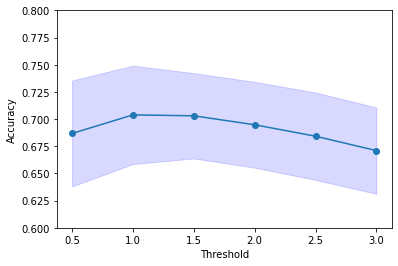

In [43]:
param_range=[0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

plt.plot([0.5, 1.0, 1.5, 2.0, 2.5, 3.0], scores_mean, marker="o")
plt.fill_between(param_range,
                 np.array(scores_mean) + np.array(scores_std),
                 np.array(scores_mean) - np.array(scores_std), alpha=0.15, 
                 color='blue')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.ylim([0.6, 0.8])
plt.show()